In [1]:
import os
import openai

In [2]:


print("Check environment\n---------------------")

pinecone_api_key = os.environ.get('PINECONE_API_KEY') or ""

print("pinecone_api_key:", pinecone_api_key)


# openai doesn't need to be initialized, but need to set api key
os.environ["OPENAI_API_KEY"] = ""

Check environment
---------------------
pinecone_api_key: 


## Read Data

In [2]:
import pandas as pd
df_images = pd.read_csv('images/images.csv')

In [3]:
import json
import pandas as pd

# Path to your JSON file
file_path = 'listings/listings_0.json'

# Lists to store image IDs and item names
image_ids = []
img_paths = []
item_names = []
feature_list = []
# other_images_ids = []

count = 0
# Open and read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        one_entry_img_paths = []
        # Parse the JSON data from each line
        json_data = json.loads(line)
        if 'main_image_id' in json_data and 'item_name' in json_data:
            if json_data['item_name'][0]['language_tag'].startswith('en'):
                image_id = json_data['main_image_id']
                item_name = json_data['item_name'][0]['value']
                image_path = df_images[df_images['image_id'] == image_id]['path'].tolist()[0]
                one_entry_img_paths.append(image_path)
                if 'other_image_id' in json_data:
                    other_ids = json_data['other_image_id']
                    for ids in other_ids:
                        im_path = df_images[df_images['image_id'] == image_id]['path'].tolist()[0]
                        one_entry_img_paths.append(im_path)
                else:
                    other_ids = ''
                # Collect bullet points if they exist and are in English
                if 'bullet_point' in json_data:
                    bullets = [bp['value'] for bp in json_data['bullet_point'] if bp['language_tag'].startswith('en')]
                    bullet_text = '; '.join(bullets)  # Join all bullet points into a single string
                else:
                    bullet_text = ''
                
                img_paths.append(one_entry_img_paths)
                image_ids.append(image_id)
                item_names.append(item_name)
                feature_list.append(bullet_text)
                # other_images_ids.append(other_ids)
                count+=1
                if count == 100:
                    break




In [4]:
metadata = {
    'primary_image_id': image_ids,
    'image_path': img_paths,
    'item_name': item_names,
    'features': feature_list
}

In [5]:

main_json = {}

for i, p_id in enumerate(metadata['primary_image_id']):

    # pid_to_int = {}
    single_entry = {'item_name': metadata['item_name'][i], 'features': metadata['features'][i], 'image_paths': []}

    for path in metadata['image_path'][i]:

        single_entry['image_paths'].append(path)

    main_json[p_id] = single_entry

In [7]:
import json

# Specify the file name
filename = 'mainjson.json'

# Writing JSON data
with open(filename, 'w') as f:
    json.dump(main_json, f, indent=4)

In [8]:
count_id = 0

pid_to_int_id = {}
img_paths_to_int_id = {}
for i, pid in enumerate(main_json):

    for path in main_json[pid]['image_path']:

        pid_to_int_id[count_id] = pid
        img_paths_to_int_id[count_id] = path

        count_id+=1



In [9]:
# Specify the file name
filename = 'pid_to_int_id.json'

# Writing JSON data
with open(filename, 'w') as f:
    json.dump(pid_to_int_id, f, indent=4)


In [10]:
# Specify the file name
filename = 'img_paths_to_int_id.json'

# Writing JSON data
with open(filename, 'w') as f:
    json.dump(img_paths_to_int_id, f, indent=4)

## PineconeDB

In [2]:
from pinecone import ServerlessSpec, Pinecone

/home/athenaai/anaconda3/envs/pinecone2/lib/python3.11/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
INDEX_NAME = 'pd-embeddings'
pc = Pinecone(api_key=pinecone_api_key)


NameError: name 'Pinecone' is not defined

In [4]:
pc.list_indexes().names()

['pd-embeddings', 'titles-embeddings']

In [5]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

In [17]:
# check if index already exists (it shouldn't if this is first time)
if INDEX_NAME not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        INDEX_NAME,
        dimension=2048,  # dimensionality of minilm
        metric='euclidean',
        spec=spec
    )

In [15]:
pc.describe_index(name=INDEX_NAME)

{'dimension': 2048,
 'host': 'pd-embeddings-lr0yl3m.svc.aped-4627-b74a.pinecone.io',
 'metric': 'euclidean',
 'name': 'pd-embeddings',
 'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
 'status': {'ready': True, 'state': 'Ready'}}

In [6]:
product_listing_index = pc.Index(INDEX_NAME)

## Image Embeddings

In [7]:
import pandas as pd
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np



# Pre-trained ResNet50 model setup
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # Remove the last layer
model.eval()  # Set the model to evaluation mode

# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract features
def extract_features(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():  # No need to compute gradients
        features = model(image)
    return features.flatten().numpy()




/home/athenaai/anaconda3/envs/pinecone2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/athenaai/anaconda3/envs/pinecone2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
int_id_to_embedding = {}
for int_id, img_path in img_paths_to_int_id.items():
    # embeddings = []
    # for img_path in img_paths:
    emb = extract_features('images/small/'+img_path)
    int_id_to_embedding[int_id] = emb

In [24]:
for int_id, emb in int_id_to_embedding.items():

    product_listing_index.upsert(
        vectors=[
            {
                "id": str(int_id), 
                "values": emb, 
                # "metadata": {"genre": "drama"}
            },
        ],
        namespace= "ns1"
    )

In [19]:
query_img_path = 'images/small/0d/0d0a19a2.jpg'
query_emb = extract_features(query_img_path).tolist()
print(len(query_emb))
# now query
search_result = product_listing_index.query(namespace="ns1", vector=query_emb, top_k=5, include_values=True)
out_ids = []
for result in search_result['matches']:
    print(f"{round(result['score'], 2)}: {result['id']}")
    out_ids.append(result['id'])
    # print(result)

2048
353.96: 146
353.96: 143
353.96: 144
353.96: 142
353.96: 141


In [20]:
out_ids

['146', '143', '144', '142', '141']

In [21]:
out_paths = []
product_titles = []
for id  in out_ids:
    out_paths.append(img_paths_to_int_id[int(id)])
    main_pid = pid_to_int_id[int(id)]
    product_titles.append(main_json[main_pid]['item_name'])

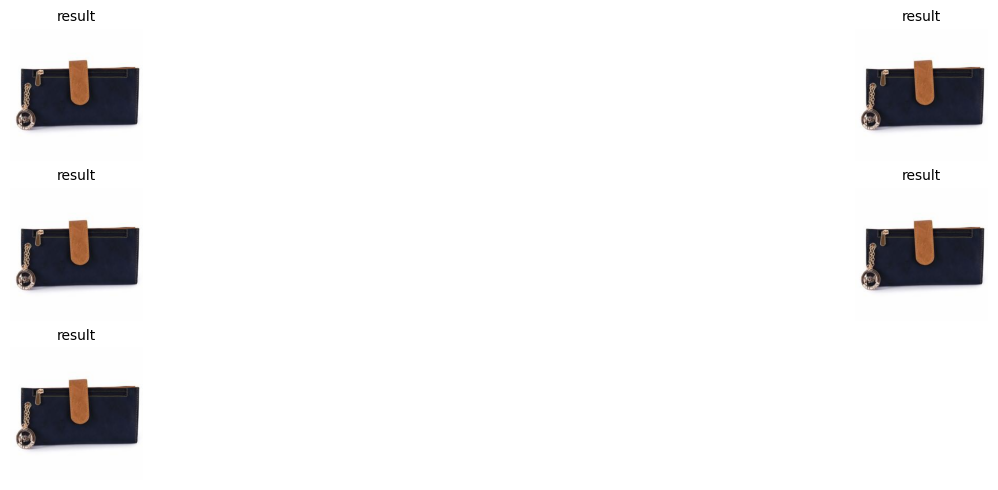

In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Plot the images if we collected any
if out_paths:
    plt.figure(figsize=(20, 10))  # Adjust figure size to give more space for titles
    for i, img_path in enumerate(out_paths, 1):
        img = mpimg.imread('/home/athenaai/Desktop/Product-Listing/images/small/'+img_path)
        plt.subplot(5, 2, i)
        plt.imshow(img)
        plt.title('result', fontsize=10)  # Set the item name as the title of each subplot
        plt.axis('off')  # Hide the axes
    plt.show()
else:
    print("No images to display.")

## Text Emb

In [8]:
# openai embedding function
def embed(docs: list[str]) -> list[list[float]]:
    res = openai.embeddings.create(
        input=docs,
        model="text-embedding-ada-002"
    )
    doc_embeds = [r.embedding for r in res.data]
    return doc_embeds

In [9]:
import json
with open('mainjson.json' , 'r') as file:
    main_json = json.load(file)

In [10]:
with open('pid_to_int_id.json', 'r') as file2:
    pid_to_int_id = json.load(file2)

In [11]:
intid_to_item_name_and_features = {}

for id, item in pid_to_int_id.items():
    title = main_json[item]['item_name']
    description = main_json[item]['features']
    intid_to_item_name_and_features[id] = title + description

In [12]:
# Specify the file name
filename = 'intid_to_item_name_and_features.json'

# Writing JSON data
with open(filename, 'w') as f:
    json.dump(intid_to_item_name_and_features, f, indent=4)

In [13]:
len(intid_to_item_name_and_features)

480

In [19]:
title_feature_embs = {}
for id, title in intid_to_item_name_and_features.items():
    emb = embed(title)
    title_feature_embs[id] = emb[0]
    

In [20]:
len(title_feature_embs)

480

In [21]:
INDEX_NAME_2 = 'text-embeddings'


In [22]:


# check if index already exists (it shouldn't if this is first time)
if INDEX_NAME_2 not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        INDEX_NAME_2,
        dimension=1536,  # dimensionality of minilm
        metric='euclidean',
        spec=spec
    )
pc.describe_index(name=INDEX_NAME_2)

{'dimension': 1536,
 'host': 'text-embeddings-lr0yl3m.svc.aped-4627-b74a.pinecone.io',
 'metric': 'euclidean',
 'name': 'text-embeddings',
 'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
 'status': {'ready': True, 'state': 'Ready'}}

In [23]:
text_emb_index = pc.Index(INDEX_NAME_2)

In [24]:

for int_id, emb in title_feature_embs.items():
    # print(emb)
    text_emb_index.upsert(
        vectors=[
            {
                "id": str(int_id), 
                "values": emb, 
                # "metadata": {"genre": "drama"}
            },
        ],
        namespace= "ns1"
    )

## Sample Query 

In [26]:
with open('img_paths_to_int_id.json', 'r') as file3:
    img_paths_to_int_id = json.load(file3)

In [28]:
query_img_path = img_paths_to_int_id['0']
query_title = intid_to_item_name_and_features['0']


In [31]:
query_emb = extract_features('images/small/'+query_img_path).tolist()
print(len(query_emb))
# now query
search_result = product_listing_index.query(namespace="ns1", vector=query_emb, top_k=15, include_values=True)
out_ids_img = {}
for result in search_result['matches']:
    print(f"{round(result['score'], 4)}: {result['id']}")
    out_ids_img[result['id']] = round(result['score'], 4)
    # print(result)

2048
0.0: 1
0.0: 2
0.0: 0
413.5689: 150
413.5689: 151
413.5689: 148
413.5689: 147
413.5689: 149
414.8608: 425
414.8608: 423
414.8608: 422
414.8608: 424
414.8608: 421
417.7397: 112
417.7397: 116


In [33]:
query_title_emb = embed(query_title)[0]
print(len(query_title_emb))
# now query
search_result_title = text_emb_index.query(namespace="ns1", vector=query_title_emb, top_k=15, include_values=True)
out_ids_title = {}
for result in search_result_title['matches']:
    print(f"{round(result['score'], 4)}: {result['id']}")
    out_ids_title[result['id']] = round(result['score'], 4)

    # print(result)

1536
0.0: 1
0.0: 0
0.0: 2
0.4018: 360
0.4018: 362
0.4018: 361
0.4018: 359
0.4018: 363
0.4264: 322
0.4264: 319
0.4264: 320
0.4264: 321
0.4265: 300
0.4265: 298
0.4265: 299


In [34]:
# Find the intersection of keys and get the corresponding key-value pairs from both dictionaries
common_pairs = {key: (out_ids_img[key], out_ids_title[key]) for key in out_ids_img.keys() & out_ids_title.keys()}

print(common_pairs)


{'1': (0.0, 0.0), '2': (0.0, 0.0), '0': (0.0, 0.0)}


In [35]:
len(common_pairs)

3

In [36]:
# Calculate the weighted average for each key
weighted_averages = {key: (value[0] + value[1]) / 2 for key, value in common_pairs.items()}

# Convert the dictionary to a list of tuples and sort it by the weighted average
sorted_weighted_averages = sorted(weighted_averages.items(), key=lambda item: item[1])

# Get the top 4 keys based on the sorted weighted averages
top_4_keys = [item[0] for item in sorted_weighted_averages[:3]]

# Print the top 4 keys
print(top_4_keys)

['1', '2', '0']


In [40]:
sorted_weighted_averages

[('1', 0.0), ('2', 0.0), ('0', 0.0)]

In [38]:
out_paths = []
out_titles = []
for key in top_4_keys:
    out_paths.append(img_paths_to_int_id[key])
    out_titles.append(intid_to_item_name_and_features[key])

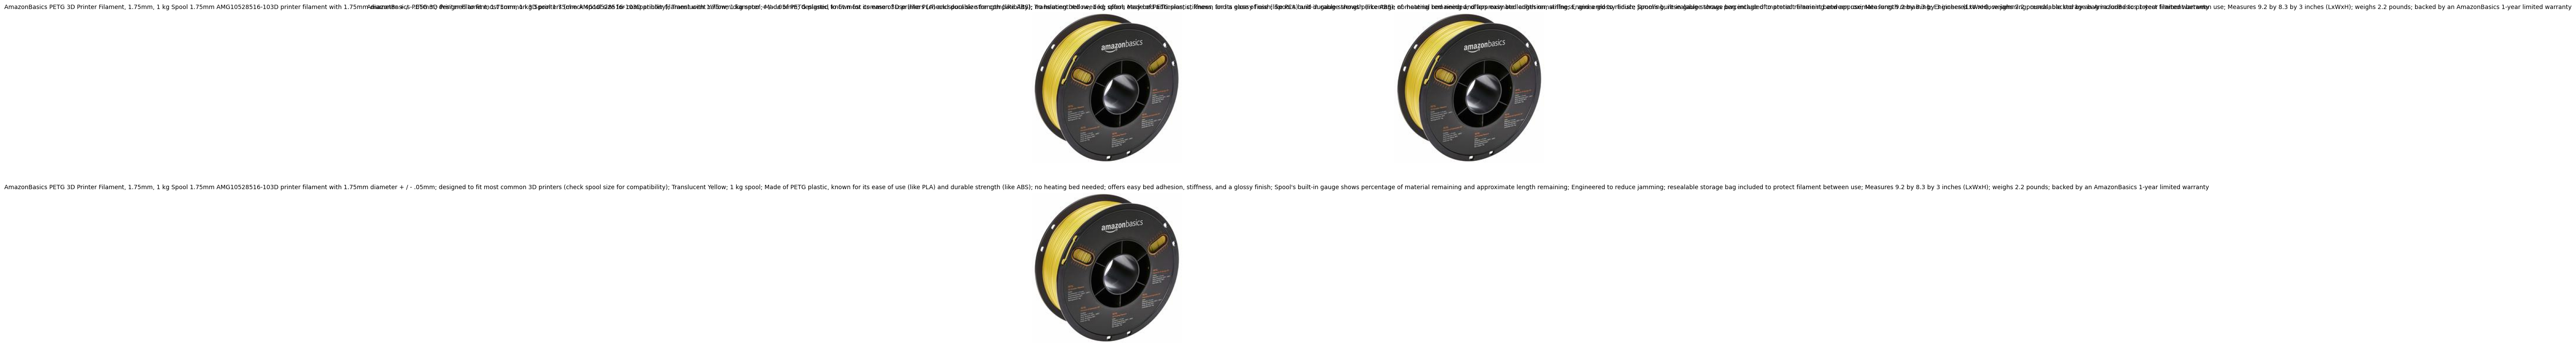

In [39]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Plot the images if we collected any
if out_paths:
    plt.figure(figsize=(20, 10))  # Adjust figure size to give more space for titles
    for i, (img_path, item_name) in enumerate(zip(out_paths, out_titles), 1):

        img = mpimg.imread('/home/athenaai/Desktop/Product-Listing/images/small/'+img_path)
        plt.subplot(2, 2, i)
        plt.imshow(img)
        plt.title(item_name, fontsize=10)  # Set the item name as the title of each subplot
        plt.axis('off')  # Hide the axes
    plt.show()
else:
    print("No images to display.")